### Introduction

When you travel, have you ever asked:<br>
"When should I visit?"<br>
"Where should I book my accommodation?"<br>
"Where are the areas like?"<br>
I tried to answer these questions with data from AirBNB Seattle.

First, let's take a look at the data, and see how we might answer these questions.

To get started, let's read in the necessary libraries we will need to wrangle our data: pandas and numpy. Matplotlib is a good library for building some basic plots.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import utils
import matplotlib.pyplot as plt

After importing the libraries, let's import data.

In [2]:
# Import data
# indicate the file paths
input_listings = './data/seattle/listings.csv'
input_calendar = './data/seattle/calendar.csv'

# read csv files
listings = pd.read_csv(input_listings)
calendar = pd.read_csv(input_calendar)

### Business Understanding

Based on the available data, we ask ourself the following questions.<br>
- What is the busiest time to visit Seattle?
- Which are popular neighborhoods?
- What are the neighborhoods like?

For answering these questions, we will use data from calendar and listings databases.

### Data Understanding

Here, we get a first overview of the data available to us.

In [3]:
listings.head(1)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07


In [4]:
calendar.head(1)

,listing_id,date,available,price
0,241032,04/01/2016,t,$85.00


<code>listings</code> contains information about the property such as the location, amentities, descriptions and requirements, etc.<br>
<code>calendar</code> tells if a property is available on a certain date, and the price (if available).

### Data Preparation

This section is about cleansing data, transforming data into desired formats for further analysis.

#### Convert data types

From earlier analysis, we notice that the price is an object. So, I am going to convert it to a float. 

In [ ]:
# Here I define a function to convert a price in string to a float
def convert2float(numeric_in_string):
    '''
    Converts a number in string to float
    :param numeric_in_string: number in string
    :return: number in float
    '''
    if pd.isna(numeric_in_string):
        p = numeric_in_string
    else:
        p = float(numeric_in_string.strip("$").replace(',', ''))
    return p

In [ ]:
# Remove $ sign from price and convert price in str to float
calendar['price'] = calendar['price'].apply(lambda x:convert2float(x))

In [7]:
# Convert the date object in calendar to datatime object and get the year and month
d = pd.DatetimeIndex(calendar['date'], dayfirst=True)
calendar['date'] = d.strftime("%d/%m/%Y")
calendar['year'] = d.year
calendar['month'] = d.month

#### Handle missing values

When the property is not available, the price returns NaN. These are the missing values. We will need to fix it. 

I'm going to fill the missing values with a valid preceding value. It assumes that the missing value is likely to be same as its previous value. 

For properties which have no preceding values, I am going to fill it using backward filling.

In [50]:
# fill missing price value for each id group
calendar_copy = calendar.copy()
calendar_copy['price'] = calendar_copy.groupby(by=['listing_id'])['price'].ffill().bfill()

#### Remove unnecessary columns

I would not use the url for this analysis, I am going to remove these columns from <code>listings</code>.

In [8]:
# Remove unused columns in listings
not_required_columns = ['listing_url', 'scrape_id', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 
                        'host_url', 'host_thumbnail_url', 'host_picture_url'
                       ]
listings_df = listings[listings.columns[~listings.columns.isin(not_required_columns)]]

### Answer research questions

###	Q1 - What is the busiest time to visit Seattle in 2016?

This question asks specifically about 2016. The first thing is to remove the data outside 2016. 

In [9]:
# exclude those data for 2017
calendar = calendar[calendar['year'] < 2017]

Next, I created a crosstab table to show the distribution of properties availability of each month.

I assume that when a property is <b>not available</b>, it means it’s <b>booked</b>.

In [10]:
# create a table to find the proportion of available properties to total
ax = pd.crosstab(calendar['month'], calendar['available']).apply(lambda r: r/r.sum()*100, axis=1)
ax

available,f,t
month,,
1,45.010193,54.989807
2,33.735012,66.264988
3,28.857101,71.142899
4,33.474881,66.525119
5,32.615115,67.384885
6,32.834436,67.165564
7,37.928208,62.071792
8,35.990254,64.009746
9,33.093166,66.906834


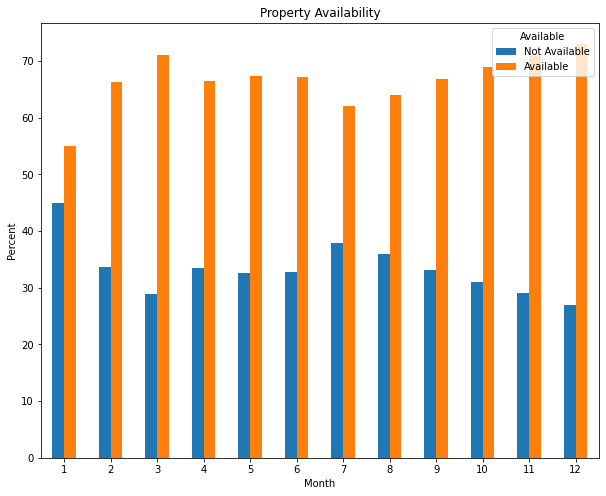

In [11]:
# plot properties availability
ax_1 = ax.plot.bar(figsize=(10,8), stacked=False, rot=0)
L = plt.legend(loc='upper right', title="Available")
L.get_texts()[0].set_text('Not Available')
L.get_texts()[1].set_text('Available')
plt.title("Property Availability")
plt.xlabel("Month")
plt.ylabel("Percent")
plt.show()

### Insights
The busiest time to visit Seattle is January. January has the least amount of available rental properties on AirBnB. 

### Q2. Where are popular properties located?

Next, I am interested in the areas where the popular properties are located.<br>

First, let’s define popular properties. Since I assumed that the unavailable properties equal to rented properties, if some properties are rented out more often than the others. They are popular properties. To do this, we need to define a cut-off point.<br>

This dataset covers a full year. I assume that if a property was rented out for more than 90% of the times in a year, it’s a popular property. This is the cut-off point I’m going to use.

In [12]:
# Define cutoff point
popular_cutoff = 365 *.9

To get started, let's create a subset of unavailable properties, then did a count on the date to find out how many days a particular property is not available. If the date count is greater than the cut off point, select the properties and save it as popularProperties. Then extract the <code>listing_id</code> from popularProperties. The <code>listing_id</code> allows us to extract the property details from <code>listings</code>.

In [13]:
# create a subset for unavailable property
unavailableProperties = calendar[calendar['available'] == 'f']

# group the dataset by listing_id, do a row count by date
unavailablePropertiesSummary = unavailableProperties.groupby(by=['listing_id'])['date'].count().reset_index().rename(columns={'date':'date_count'}).sort_values(by ='date_count', ascending=False)

# Find out the listing_id being available with <10% of a year
popularProperties = unavailablePropertiesSummary[unavailablePropertiesSummary['date_count']>popular_cutoff]

# extract the listing_id for popular properties
popularPropertiesID = popularProperties['listing_id'].tolist()

# Create a subset for popular properties listings
popularPropertiesListings = listings_df[listings_df['id'].isin(popularPropertiesID)]

In [18]:
# find out the first 25 common neighbourhoods
feq = popularPropertiesListings['neighbourhood_cleansed'].value_counts().sort_values(ascending=True)
feq = feq[-25:]

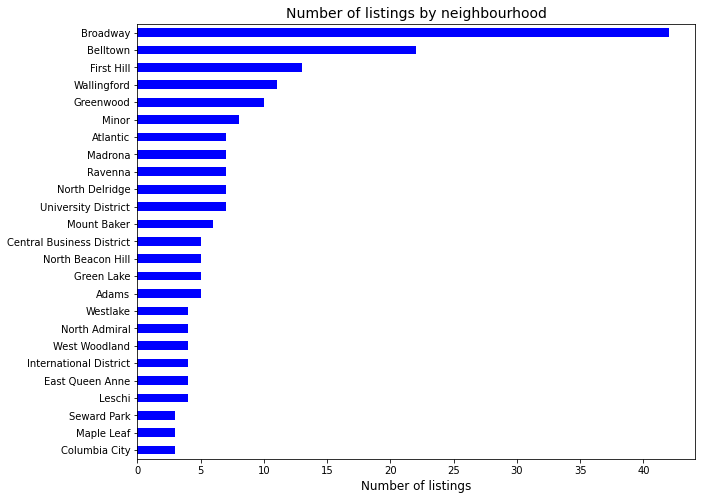

In [19]:
# plot the bar chart
feq.plot.barh(figsize=(10,8), color ='b', width= 0.5)
plt.title('Number of listings by neighbourhood', fontsize=14)
plt.xlabel('Number of listings', fontsize = 12)
plt.show()

### Insights


The number of listings in Broadway is 2 times more than the Belltown. It's possibly because the Broadway district is close to Capitol Hill which is a popular area with multiple tourist attractions.

### Q3 - What is the vibe of Seattle popular neighborhood?

Lastly, I want to know about the areas in Seattle. This time, I would use wordclouds to describe the vibes of some neighbourhoods.

In order to do it, I remove the punctuations from the text. Then I remove the stopwords, which are commonly used words but not showing much information in it, and lastly, I lemmatize each word to convert it into its meaningful root.

It's also common that the district names would appear many times in the overview. But the names would not tell me much about the vibe of the neighbourhood. So, I would need to take these names out from the overview. To do it, I extract the unique value from the column <code>neighbourhood_group_cleansed</code> and save it in a list. I broke the names into tokens. These tokens will be used in the text cleasing process.

In [21]:
# define text processing functions
def clean_text(df_row, stopwords_list):
    '''
    Cleans the text on a row in a dataframe
    :param df_row: the text row in a dataframe
    :param stopwords_list: a list of words to be removed
    :return: the clean text row
    '''
    import re

    if not pd.isna(df_row):
        # remove punctuation
        output_str = re.sub(r'[^\w]+(\s+|$)', ' ', df_row).strip()
        output_str = output_str.replace('"', '')

        # remove stopwords
        filtered_words = remove_stopwords(output_str, stopwords_list)
        lemmatized_words = lemmatize_text(filtered_words)
        output_str = ' '.join(lemmatized_words)

        return output_str
    else:
        output_str = " "
        df_row = output_str
        return df_row


def remove_stopwords(df_row, stopwords_list):
    '''
    Removes common stopwords from the text row in a dataframe
    :param df_row: the text row in a dataframe
    :param stopwords_list: a list of words to be removed
    :return: text row without common stopwords
    '''
    from nltk.corpus import stopwords

    word_list = df_row.lower().split()
    filtered_words = [word for word in word_list if word not in stopwords.words('english')]
    filtered_words = [word for word in filtered_words if word not in stopwords_list]
    return filtered_words


def lemmatize_text(filtered_words_list):
    '''
    Takes a word list and converts the words into its meaningful base form
    :param filtered_words_list: a list of words after removing punctuation and stopwords
    :return: a list of words in their base forms
    '''
    from nltk.stem import WordNetLemmatizer

    lemmatized_words = []

    lemmatizer = WordNetLemmatizer()

    for word in filtered_words_list:
        lemmatized_word = lemmatizer.lemmatize(word)
        lemmatized_words.append(lemmatized_word)
    return lemmatized_words


In [24]:
# Prepare a flattened list of districts
districts = listings['neighbourhood_group_cleansed'].unique().tolist() 
districts = [town.lower().split() for town in districts]

districts_flat = [item for sublist in districts for item in sublist]

In [25]:
# preprocess text
listings['neighborhood_overview_cleaned'] = listings['neighborhood_overview'].apply(lambda x: clean_text(x, districts_flat))

In [26]:
# create wordclouds
downtown = utils.subset_dataset(listings, 'neighbourhood_group_cleansed', 'Downtown')
capitolHill = utils.subset_dataset(listings, 'neighbourhood_group_cleansed', 'Capitol Hill')
queenAnne = utils.subset_dataset(listings, 'neighbourhood_group_cleansed', 'Queen Anne')
ballard = utils.subset_dataset(listings, 'neighbourhood_group_cleansed', 'Ballard')
weatSeattle = utils.subset_dataset(listings, 'neighbourhood_group_cleansed', 'West Seattle')
northgate = utils.subset_dataset(listings, 'neighbourhood_group_cleansed', 'Northgate')
beaconHill = utils.subset_dataset(listings, 'neighbourhood_group_cleansed', 'Beacon Hill')

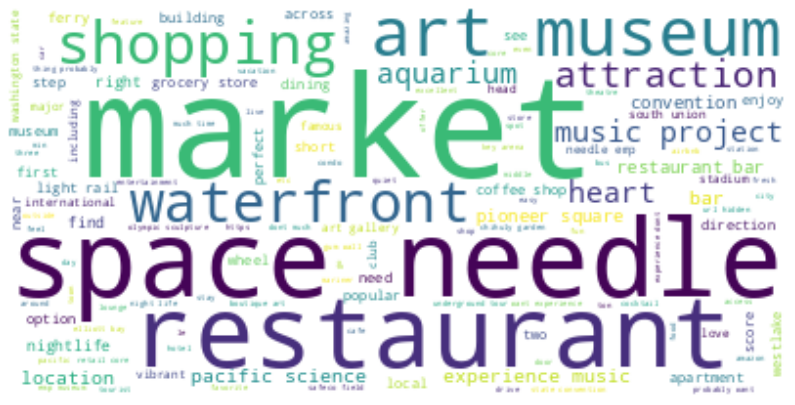

In [27]:
# display downtown wordcloud
utils.create_wordcloud(downtown, 'neighborhood_overview_cleaned')

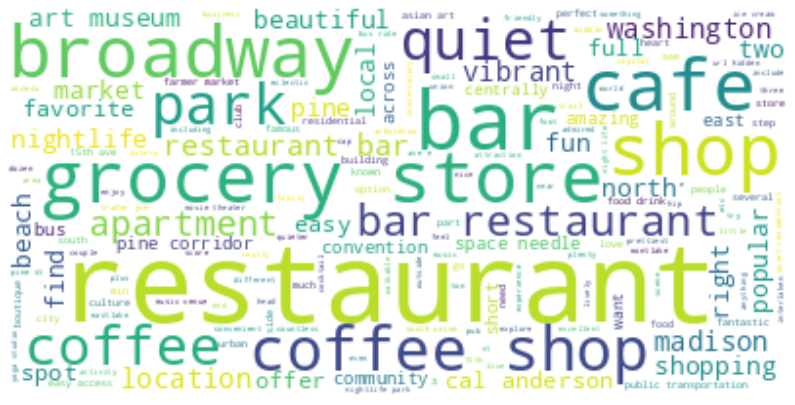

In [28]:
# display capitol hill wordcloud
utils.create_wordcloud(capitolHill, 'neighborhood_overview_cleaned')

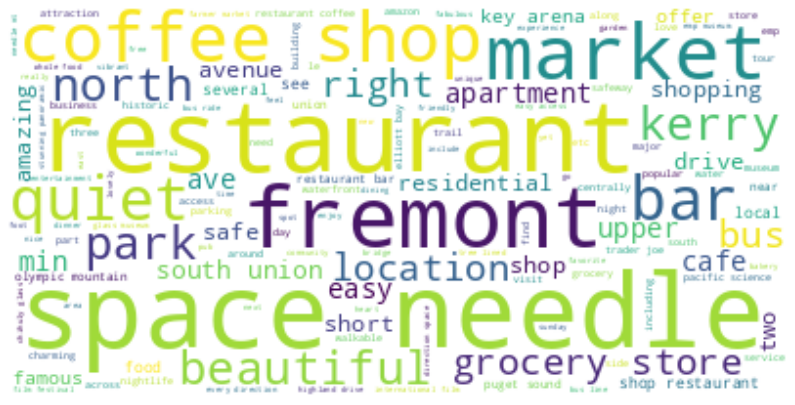

In [29]:
# display queen anne wordcloud
utils.create_wordcloud(queenAnne, 'neighborhood_overview_cleaned')

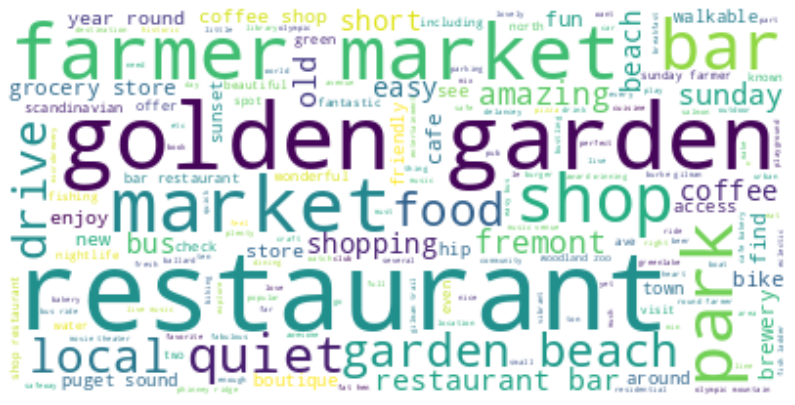

In [30]:
# display ballard wordcloud
utils.create_wordcloud(ballard, 'neighborhood_overview_cleaned')

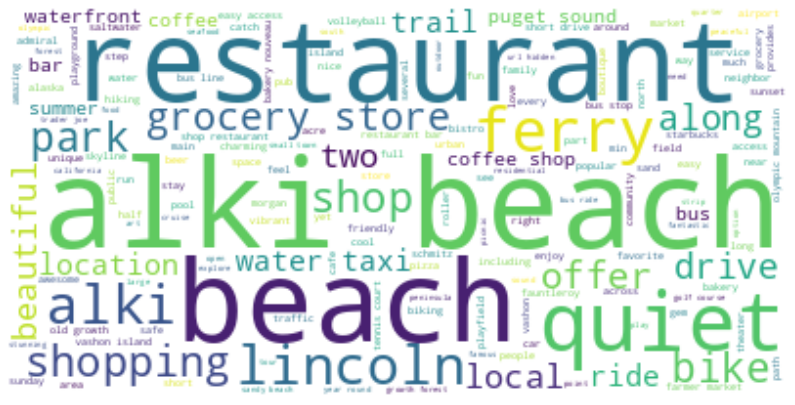

In [31]:
# display west seattle wordcloud
utils.create_wordcloud(weatSeattle, 'neighborhood_overview_cleaned')

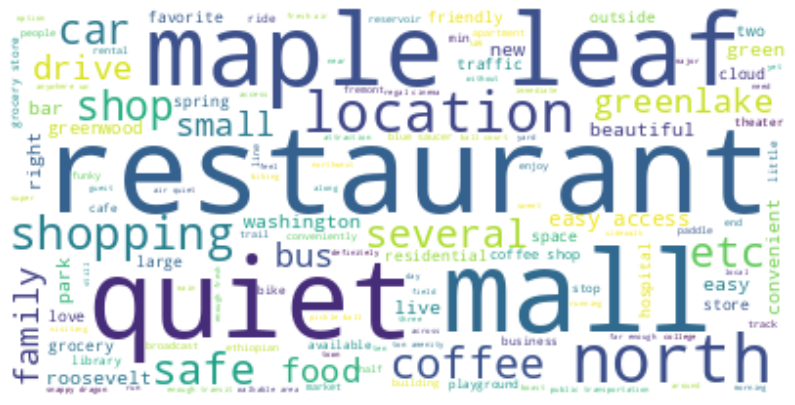

In [32]:
# display north gate wordcloud
utils.create_wordcloud(northgate, 'neighborhood_overview_cleaned')

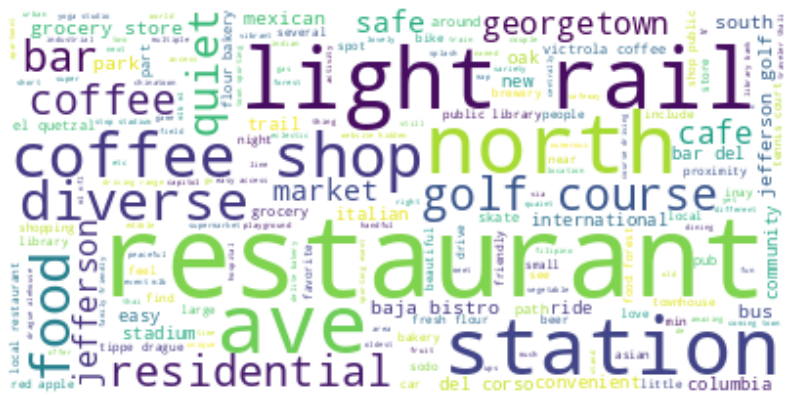

In [33]:
# display beacon hill wordcloud
utils.create_wordcloud(beaconHill, 'neighborhood_overview_cleaned')